<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [2]:
#!pip3 install --user networkx

# 1. Reading Data

In [3]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# 2. Similarity measures

## 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [4]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [5]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [6]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [7]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [8]:
print(jaccard_for_followers(273084,470294))

0


In [9]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [10]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [11]:
print(cosine_for_followees(273084,1505602))

0.0


In [12]:
print(cosine_for_followees(273084,1635354))

0


In [13]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [14]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [15]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

## 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank


In [16]:
if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))

In [17]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699365892e-07


In [18]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699365892e-07


# 4. Other Graph Features

## 4.1 Shortest path:

Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [19]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [20]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [21]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community

In [22]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [23]:
belongs_to_same_wcc(861, 1659750)

0

In [24]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [25]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [26]:
calc_adar_in(1,189226)

0

In [27]:
calc_adar_in(669354,1635354)

0

## 4.4 Is persion was following back:

In [28]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [29]:
follows_back(1,189226)

1

In [30]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [31]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))

In [32]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935504637


In [33]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935504637


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [34]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

In [35]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699353278e-07


# 5. Featurization

## 5. 1 Reading a sample of Data from both train and test

In [36]:
import random
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [37]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [38]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [39]:
df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,569324,1194578,1


In [40]:
df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,713880,167361,1


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [41]:
#if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
if True:
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    print("Addition of Jaccard & Cosine Distanc complete")

Addition of Jaccard & Cosine Distanc complete


In [42]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [43]:
#if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
if True:
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    print("Addition of Number of followers/followees complete")
    
    #hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    #hdf.put('train_df',df_final_train, format='table', data_columns=True)
    #hdf.put('test_df',df_final_test, format='table', data_columns=True)
    #hdf.close()
#else:
#    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
#    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

Addition of Number of followers/followees complete


## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [44]:
#if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
if True:
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    
    print("Addition of Adar Index, follows back and shortest parth complete")
    #hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    #hdf.put('train_df',df_final_train, format='table', data_columns=True)
    #hdf.put('test_df',df_final_test, format='table', data_columns=True)
    #hdf.close()
#else:
#    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
#    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

Addition of Adar Index, follows back and shortest parth complete


## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [45]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:14<00:00, 120154.67it/s]


In [46]:
#if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
if True:
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)
    print("Addition of weights complete")

Addition of weights complete


In [47]:
#if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
if True:    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================
    print("Addition of page rank complete")

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================
    
    print("Addition of Katz score complete")

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================
    print("Addition of HITS complete")
    
    #hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    #hdf.put('train_df',df_final_train, format='table', data_columns=True)
    #hdf.put('test_df',df_final_test, format='table', data_columns=True)
    #hdf.close()
#else:
 #   df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
 #   df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

Addition of page rank complete
Addition of Katz score complete
Addition of HITS complete


## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [48]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [49]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [50]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [51]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [52]:
#if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
if True:    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    print("Addition of SVD for Train complete")
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    print("Addition of SVD for Test complete")

    #hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    #hdf.put('train_df',df_final_train, format='table', data_columns=True)
    #hdf.put('test_df',df_final_test, format='table', data_columns=True)
    #hdf.close()

Addition of SVD for Train complete
Addition of SVD for Test complete


In [53]:
# prepared and stored the data from machine learning models
# pelase check the FB_Models.ipynb

In [54]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [55]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

## Preferential Attachment with followers and followees


In [56]:
# http://be.amazd.com/link-prediction/
# Preferential Attachment One well-known concept in social networks is that users with many friends 
#tend to create more connections in the future. 
#This is due to the fact that in some social networks, like in finance, the rich get richer. 
#We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. 
#It may be noted that the similarity index does not require any node neighbor information; 
#therefore, this similarity index has the lowest computational complexity.

In [57]:
df_final_train['pref_attachment_follower'] = df_final_train['num_followers_s'] * df_final_train['num_followers_d']
df_final_train['pref_attachment_followee'] = df_final_train['num_followees_s'] * df_final_train['num_followees_d']
df_final_test['pref_attachment_follower'] = df_final_test['num_followers_s'] * df_final_test['num_followers_d']
df_final_test['pref_attachment_followee'] = df_final_test['num_followees_s'] * df_final_test['num_followees_d']

## Dot product between sourse node svd and destination node svd features

In [58]:
df_final_train.shape

(100002, 57)

In [59]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pref_attachment_follower', 'pref_attachment_followee'],
      dtype='object')

In [60]:
df_final_train['svd_u_d_1'].head(5)

0   -2.038018e-11
1   -1.093444e-14
2   -1.913205e-11
3    1.396549e-19
4   -3.075034e-13
Name: svd_u_d_1, dtype: float64

In [66]:
#https://stackoverflow.com/questions/28639551/pandas-create-new-dataframe-column-using-dot-product-of-elements-in-each-row
df_final_train['dot_svd_u_s_d'] = df_final_train['svd_u_s_1'].dot(df_final_train['svd_u_d_1'].T) + \
                                     df_final_train['svd_u_s_2'].dot(df_final_train['svd_u_d_2'].T) + \
                                     df_final_train['svd_u_s_3'].dot(df_final_train['svd_u_d_3'].T) + \
                                     df_final_train['svd_u_s_4'].dot(df_final_train['svd_u_d_4'].T) + \
                                     df_final_train['svd_u_s_5'].dot(df_final_train['svd_u_d_5'].T) + \
                                     df_final_train['svd_u_s_6'].dot(df_final_train['svd_u_d_6'].T)
#df_final_train['dot_svd_u_s_d_1']

In [67]:
df_final_train.shape

(100002, 58)

In [70]:
df_final_test.shape

(50002, 63)

In [68]:
#https://stackoverflow.com/questions/28639551/pandas-create-new-dataframe-column-using-dot-product-of-elements-in-each-row
df_final_test['dot_svd_u_s_d'] = df_final_test['svd_u_s_1'].dot(df_final_test['svd_u_d_1'].T) + \
                                 df_final_test['svd_u_s_2'].dot(df_final_test['svd_u_d_2'].T) + \
                                 df_final_test['svd_u_s_3'].dot(df_final_test['svd_u_d_3'].T) + \
                                 df_final_test['svd_u_s_4'].dot(df_final_test['svd_u_d_4'].T) + \
                                 df_final_test['svd_u_s_5'].dot(df_final_test['svd_u_d_5'].T) + \
                                 df_final_test['svd_u_s_6'].dot(df_final_test['svd_u_d_6'].T)

In [69]:
df_final_train.drop(['svd_u_s_1', 'svd_u_d_1','svd_u_s_2','svd_u_d_2',
                     'svd_u_s_3','svd_u_d_3','svd_u_s_4','svd_u_s_5','svd_u_s_6',
                     'svd_u_d_4','svd_u_d_5','svd_u_d_6'],axis=1,inplace=True)

df_final_test.drop(['svd_u_s_1', 'svd_u_d_1','svd_u_s_2','svd_u_d_2',
                     'svd_u_s_3','svd_u_d_3','svd_u_s_4','svd_u_s_5','svd_u_s_6',
                     'svd_u_d_4','svd_u_d_5','svd_u_d_6'],axis=1,inplace=True)

In [70]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## Using RandomForest

Estimators =  10 Train Score 0.9229947308324865 test Score 0.9194334706228461
Estimators =  50 Train Score 0.926708152618015 test Score 0.9228374939536057
Estimators =  100 Train Score 0.9259387274155539 test Score 0.9219807474042626
Estimators =  250 Train Score 0.9252595372761393 test Score 0.9210305471634777
Estimators =  450 Train Score 0.9243989491422531 test Score 0.9204461903661535


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

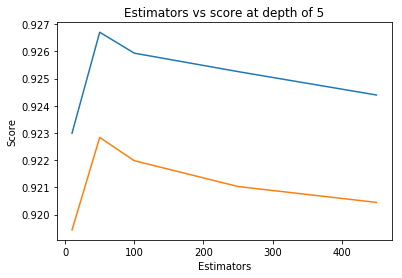

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm


estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

depth =  3 Train Score 0.8982946928680544 test Score 0.8731735329774337
depth =  9 Train Score 0.9600342040434067 test Score 0.9201869989211601
depth =  11 Train Score 0.9626819495866511 test Score 0.9272162525184688
depth =  15 Train Score 0.9651058995374503 test Score 0.9285128744088281
depth =  20 Train Score 0.9651807901009178 test Score 0.9284048164414652
depth =  35 Train Score 0.9653311147411248 test Score 0.9283777249889634
depth =  50 Train Score 0.9653311147411248 test Score 0.9283777249889634


In [74]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [98]:
#print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])
print(rf_random.best_estimator_)

#print(rf_random.cv_results_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=9, n_jobs=1,
              nthread=None, num_boost_round=250, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, verbosity=1)


In [99]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [100]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [101]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

randomforest_f1_score_train = f1_score(y_train,y_train_pred)
randomforest_f1_score_test = f1_score(y_test,y_test_pred)

Train f1 score 0.9666737724721096
Test f1 score 0.9291272344900107


In [102]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


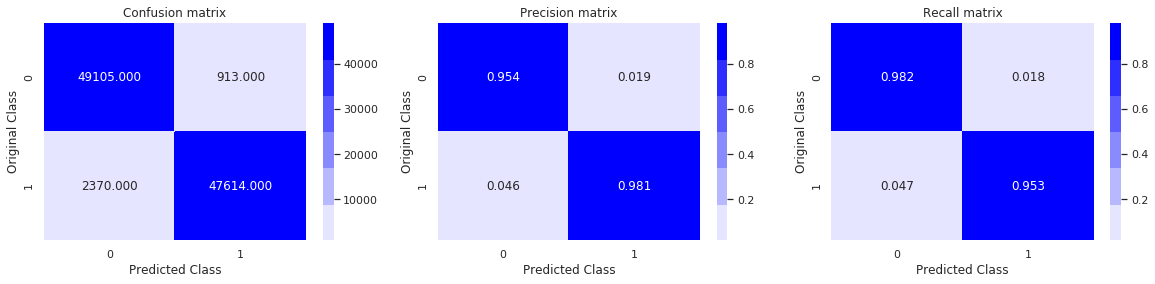

In [103]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)


Test confusion_matrix


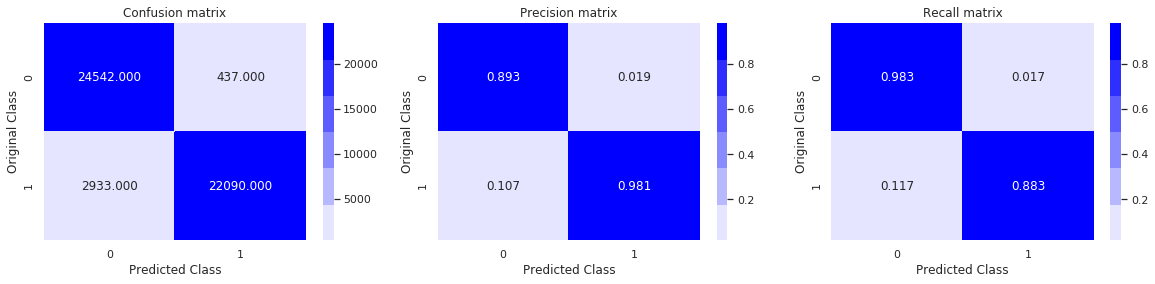

In [104]:
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

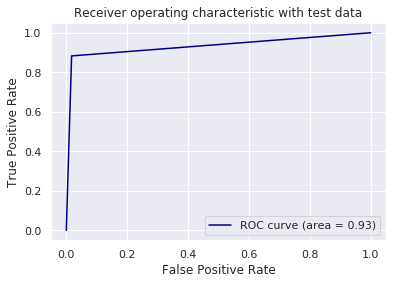

In [105]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

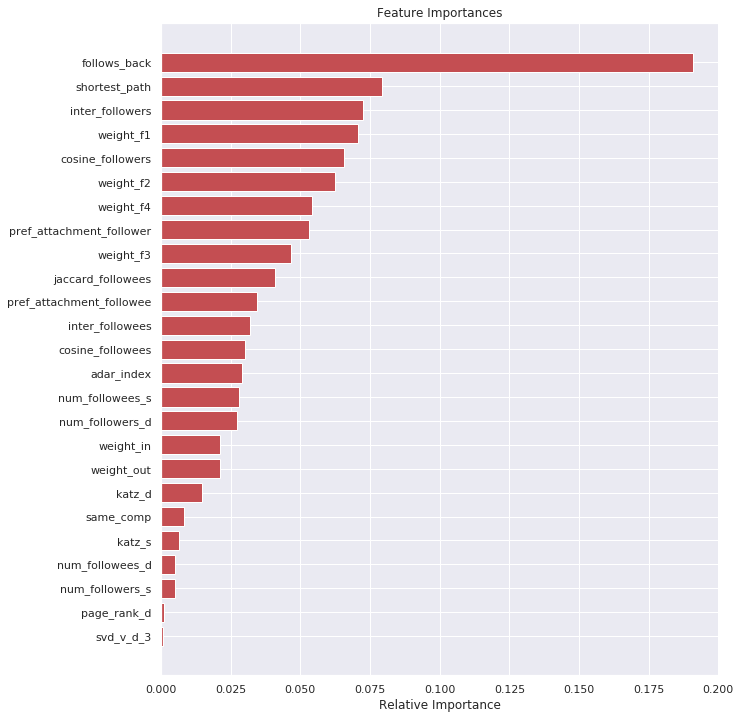

In [106]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Using XGBOOST

In [107]:
import time
#from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

start_time = time.time()

parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'n_estimators' : [3,5,7,9]
}

model = XGBClassifier()

rf_random = RandomizedSearchCV(model, param_distributions=parameters,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)

#grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
#grid.fit(df_final_train, y_train)  

# Summarize results
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Execution time: 185.5570821762085 ms


In [108]:
#print("Best: %f using %s" % (rf_random.best_score_, rf_random.best_params_))

print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])
print(rf_random.best_estimator_)

mean test scores [0.97141442 0.92808935 0.97475804 0.97434437 0.97151487]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=9, n_jobs=1,
              nthread=None, num_boost_round=250, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, verbosity=1)


In [109]:
#depth_gbdt = grid.best_params_['max_depth']
#eta_gbdt = grid.best_params_['eta']
#num_boost_rount_gbdt = grid.best_params_['num_boost_round']
#subsample_gbdt = grid.best_params_['subsample']
#colsample_bytree_gbdt = grid.best_params_['colsample_bytree']
#best_n_estimators = grid.best_params_['n_estimators']

In [110]:
depth=[2,  5,  8, 10,15]
n_est=[5, 15, 25,35, 50]

sol_train=pd.DataFrame(index=depth, columns=n_est)
for d in tqdm(depth):
    for n in n_est:
        gbdt = XGBClassifier(booster='gbtree',scale_pos_weight=1,objective='binary:logistic',
                                gamma = 0.1,eval_metric='auc',seed=100,max_depth=d,n_estimators=n)
        gbdt.fit(df_final_train, y_train.values.reshape(-1,1))
        y_prob_train = gbdt.predict_proba(df_final_train)
        fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_prob_train[:, 1])
        roc_auc_train = auc(fpr_train, tpr_train)
        sol_train.at[d,n] = roc_auc_train

#https://stackoverflow.com/questions/30485986/type-error-in-visualising-pandas-dataframe-as-heatmap
sol_train=sol_train[sol_train.columns].astype(float)

sol_test=pd.DataFrame(index=depth, columns=n_est)
for d in tqdm(depth):
    for n in n_est:
        gbdt = XGBClassifier(booster='gbtree',scale_pos_weight=1,objective='binary:logistic',
                                gamma = 0.1,etest_metric='auc',seed=100,max_depth=d,n_estimators=n)
        gbdt.fit(df_final_train, y_train.values.reshape(-1,1))
        y_prob_test = gbdt.predict_proba(df_final_test)
        fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_prob_test[:, 1])
        roc_auc_test = auc(fpr_test, tpr_test)
        sol_test.at[d,n] = roc_auc_test
        
#https://stackoverflow.com/questions/30485986/type-error-in-visualising-pandas-dataframe-as-heatmap
sol_test=sol_test[sol_test.columns].astype(float)

100%|██████████| 5/5 [05:37<00:00, 67.48s/it]


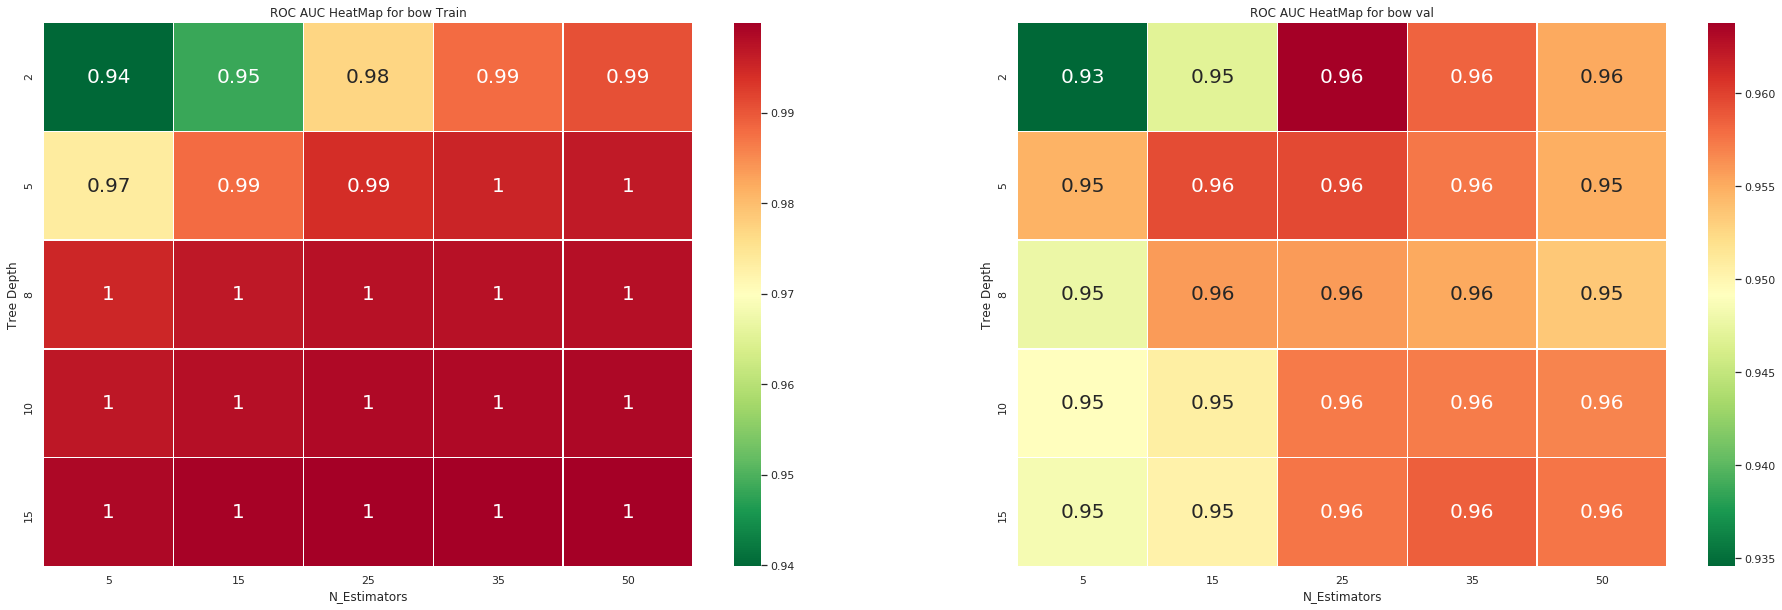

In [111]:
import seaborn as sn
fig, ax = plt.subplots(1, 2, figsize=(32,10))

sn.set(font_scale=1)#for label size
sn.heatmap(sol_train, ax=ax[0], cmap='RdYlGn_r',linewidths=0.5, annot_kws={"size": 20},annot=True)# font size
ax[0].set_xlabel('N_Estimators')
ax[0].set_ylabel('Tree Depth'); 
ax[0].set_title('ROC AUC HeatMap for bow Train'); 

sn.heatmap(sol_test, ax=ax[1], cmap='RdYlGn_r',linewidths=0.5, annot_kws={"size": 20}, annot=True)# font size
ax[1].set_xlabel('N_Estimators')
ax[1].set_ylabel('Tree Depth'); 
ax[1].set_title('ROC AUC HeatMap for bow val');

plt.show()

### Conclusion
- Best depth is 5 and best n_estimator is 5 as for all other values, the train set is overfitting.

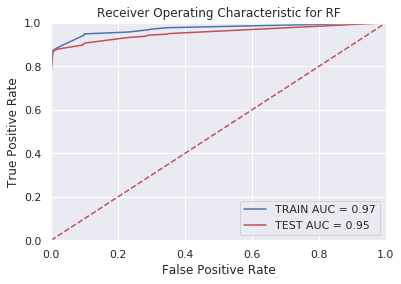

In [112]:
#xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
gbdt = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, num_boost_round=250, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, verbosity=1)

gbdt=gbdt.fit(df_final_train,y_train)

y_prob_test = gbdt.predict_proba(df_final_test)
y_prob_train = gbdt.predict_proba(df_final_train)

fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_prob_train[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_prob_test[:, 1])
roc_auc_test_gbdt = auc(fpr_test, tpr_test)

plt.title('Receiver Operating Characteristic for RF')
plt.plot(fpr_train, tpr_train, 'b', label = 'TRAIN AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'r', label = 'TEST AUC = %0.2f' % roc_auc_test_gbdt)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Train confusion_matrix


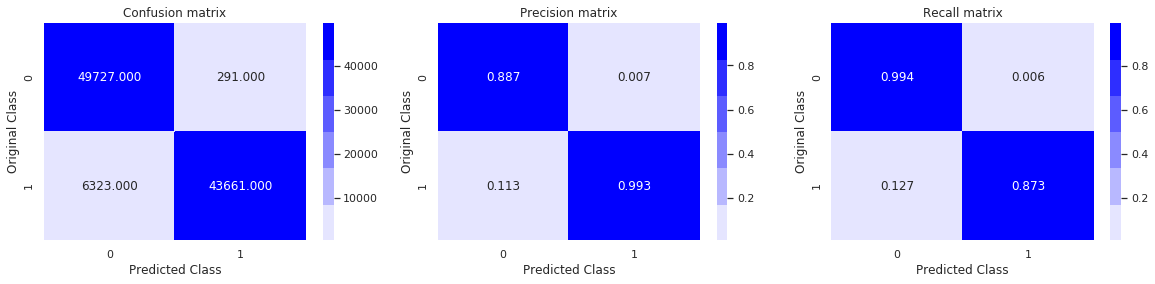

In [113]:
y_train_pred = gbdt.predict(df_final_train)
xgboost_f1_score_train = f1_score(y_train,y_train_pred)
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)

Test confusion_matrix


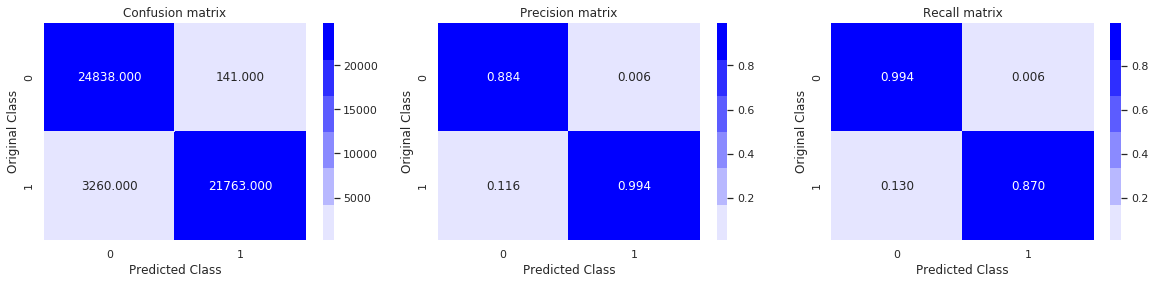

In [114]:
y_test_pred = gbdt.predict(df_final_test)
xgboost_f1_score_test = f1_score(y_test,y_test_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

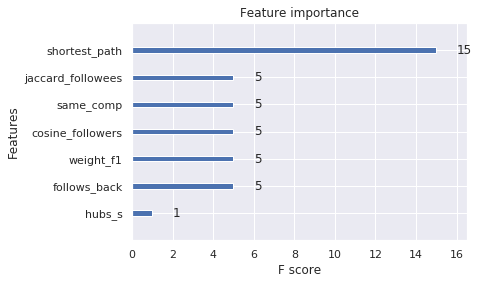

In [115]:
#https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
from xgboost import plot_importance
#feature_important = gbdt.get_score(importance_type='weight')
#keys = list(feature_important.keys())
#values = list(feature_important.values())

#data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
#data.plot(kind='barh')

plot_importance(gbdt, max_num_features = 15)
plt.show()

## Conclusion

In [116]:
#! pip3 install --user prettytable

In [117]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Depth", "N_Estimators", "AUC Score",'Train F1','Test F1']

x.add_row(["Random Forest",14,121,auc_sc,randomforest_f1_score_train, randomforest_f1_score_test])
x.add_row(["GBDT using XGBOOST",5,5,roc_auc_test_gbdt,xgboost_f1_score_train,xgboost_f1_score_test])
print(x)

+--------------------+-------+--------------+--------------------+--------------------+--------------------+
|       Model        | Depth | N_Estimators |     AUC Score      |      Train F1      |      Test F1       |
+--------------------+-------+--------------+--------------------+--------------------+--------------------+
|   Random Forest    |   14  |     121      | 0.9326465698236833 | 0.9666737724721096 | 0.9291272344900107 |
| GBDT using XGBOOST |   5   |      5       | 0.9548305346502652 | 0.9295903593936298 | 0.927525731455239  |
+--------------------+-------+--------------+--------------------+--------------------+--------------------+
